<img src="media/coco-banner.jpg">

# Xarray

[_Xarray_](https://docs.xarray.dev/) is a Python package that makes working with labelled multi-dimensional arrays (like stacks of images) in Python simple, efficient, and fun. It has extensions for specific domains, for example the [Rioxarray](https://corteva.github.io/rioxarray) adds functionality for geospatial raster data. The name "RIO" comes from "RasterIO"(Input/Output), because the extension makes use of yet another great open source package [RasterIO](https://rasterio.readthedocs.io).   

In this notebook we will learn about:
* How to scale analysis with *lots* of images using [Microsoft's Planetary Computer](https://planetarycomputer.microsoft.com/)
* How [Geopandas](https://github.com/geopandas/geopandas) and Xarray work together for GIS-like functionality
* Examine how NDVI changes over several years at Mt Rainer, Washington State
                                                     
---

Xarray hace que trabajar con datos n-dimensionales (conjuntos de imagenes) sea sencillo, eficaz, y divertido! Tiene extenciones para varios dominios cientificos, por ejemplo Rioxarray aggrega funciones para trabajar con datos cuadriculares geospaciales (imagenes de satellite) comun en geociencias. El nombre 'RIO' viene de "RasterIO" (IO = Input/Output), porque la extencion utiliza otro paquete libre en Python: RasterIO.

Vamos a aprender:
* Empezar a analysis conjuntos de imagenes con Microsoft Planetary Computer
* Utilizar Geopandas y Xarray juntos para analysis geospacial
* Ver cambios de NDVI alrededor de Mt. Rainier, Washington State

In [1]:
import xarray as xr
import geopandas as gpd
import os

import planetary_computer 
import pystac_client
import odc.stac

import matplotlib.pyplot as plt

## DataSet (combining data) | DataSet (agregar datos)

An Xarray `DataSet` let's you store multiple variables in the same data structure. For example, different physical observables that share the same dimensions. Here we store different [Landsat Bands with their common names](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites) in order to calculate the widely used [Normalized Difference Vegetation Index](https://www.usgs.gov/landsat-missions/landsat-normalized-difference-vegetation-index).

---

Un `DataSet` es el objecto de Xarray para guardar variables differentes.  Por ejemple, observaciones physicas distintas las cuales comparten las mismas dimensiones. Aqui guardamos landsat bandas diferentes segun su nombre comun para calcular el NDVI un indice común para evaluar el estado de salud vegetación.

![Xarray Diagram](https://docs.xarray.dev/en/stable/_images/dataset-diagram.png)

In [2]:
# Same file from 09_RasterioIntro.ipynb (NIR)
daB5 = xr.open_dataarray('./data/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B5_OV2.tif', 
                         engine='rasterio',
                        )

# Also open B5 from the same acquisition date
daB4 = xr.open_dataarray('./data/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B4_OV2.tif', 
                         engine='rasterio',
                        )

# Use common names for each DataArray
daB4 = daB4.assign_coords(band=['red'])
daB5 = daB5.assign_coords(band=['nir'])

In [3]:
daB4.to_netcdf('test.nc', engine='netcdf4')

In [4]:
# Combine along 'band' dimension
da2 = xr.concat([daB5, daB4], dim='band')
da2

<xarray.DataArray 'band_data' (band: 2, y: 987, x: 972)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) <U3 'nir' 'red'
  * x            (x) float64 4.735e+05 4.737e+05 ... 7.062e+05 7.064e+05
  * y            (y) float64 5.373e+06 5.373e+06 ... 5.137e+06 5.137e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point

In [5]:
# Convert to a DataSet (note that we move the 'band' dimension to named Data Variables
ds = da2.to_dataset(dim='band')
ds

<xarray.Dataset>
Dimensions:      (y: 987, x: 972)
Coordinates:
  * x            (x) float64 4.735e+05 4.737e+05 ... 7.062e+05 7.064e+05
  * y            (y) float64 5.373e+06 5.373e+06 ... 5.137e+06 5.137e+06
    spatial_ref  int64 0
Data variables:
    nir          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    red          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    AREA_OR_POINT:  Point

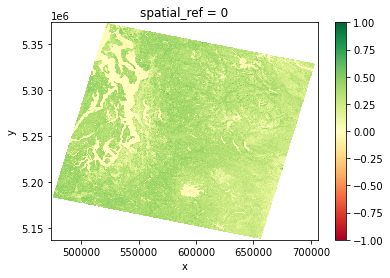

In [6]:
ndvi = (ds.nir - ds.red) / (ds.nir + ds.red)

ndvi.plot(cmap='RdYlGn', vmin=-1, vmax=1);

In [7]:
# Recall our CRS is UTM:
ndvi.rio.crs

CRS.from_epsg(32610)

## Geopandas (points,lines,polygons) | Geopandas (puntos, lineas, poligonos)

Longmire, WA is one of the entrances to Mt. Rainier National Park, let's caculate the NDVI at that location (121.8128W, 46.7502N). For Points, Lines, and Polygons, the Geopandas extension to Pandas is an indispensible tool. It adds geospatial functionality in the same way that Rioxarray extends Xarray:

---

Longmire, Washington State es uno de las entradas al parque nacional de Mt Rainier. Calculemos NDVI en Longmire (121.8128 lon, 46.7502 lat). Para trabajar con puntos, lineas, y poligonos el paquete Geopandas extende a Pandas y es una hierramienta indispensible. 

In [8]:
gf = gpd.GeoDataFrame(data={'name':['longmire']}, 
                      geometry=gpd.points_from_xy([-121.8128], [46.7502]), 
                      crs='EPSG:4326')
gf

,name,geometry
0,longmire,POINT (-121.81280 46.75020)


In [9]:
# Reproject this point to the same CRS as our raster for easy sampling
gf_utm = gf.to_crs(ndvi.rio.crs)
gf_utm

,name,geometry
0,longmire,POINT (590676.978 5178089.660)


In [10]:
xval = gf_utm.geometry.x.values
yval = gf_utm.geometry.y.values

In [11]:
ndvi.sel(x=xval, 
         y=yval, 
         method='nearest')

<xarray.DataArray (y: 1, x: 1)>
array([[0.22127697]], dtype=float32)
Coordinates:
  * x            (x) float64 5.908e+05
  * y            (y) float64 5.178e+06
    spatial_ref  int64 0

## Practice exercise: (5 minutes)

**Plot East-West and North-South profiles through Mt. Rainier Summit (-121.726, 46.879)**

---

**Crear una figura con perfil de NDVI pasando por la cima de Mt Rainier (-121.726, 46.879)**

## Timeseries | Serie de tiempo


### Planetary Computer (search for data) | Planetary Computer (descubrir datos)
If you're interested in computing changes of time, you often end up needing to find and read 100s or even 1000s of satellite images. While it is possible to construct DataSets like we did above piece by piece, there are other software packages that build on top of Xarray to simplify this for you. Computations that require a lot of data are best run where the large datasets are hosted. This is why Microsoft [Planetary Computer provides a JupyterHub](https://planetarycomputer.microsoft.com/docs/overview/environment/) in the same region as the data archives.

---

Si quieres calcular cambios por el tiempo, vas a necesitar cienes o miles de imagenes satelitales. Es posible construir DataSets como hicimos arriba poco a poco, pero hay otro software que nos facilita el proceso. Computaciones que requieren muchos datos son muchos mas rapidos si las hace en el mismo centro de datos, es por eso MS Planetary Computer proviene un JupyterHub.

In [12]:
bbox_of_interest = [-122.0, 46.7, -121.5, 47.0]
time_of_interest = "2020-01-01/2022-12-31" #NOTE: L8 launched 02/2013, L9 launched 09/2021

In [13]:
%%time

# if you have an account (https://planetarycomputer.developer.azure-api.net/profile)
#os.environ['PC_SDK_SUBSCRIPTION_KEY'] = 'fgh1cc0c158a493f9bce23564c667856'  
# Always set this when reading from URLs
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR'

catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections=["landsat-c2-l2"],
                        bbox=bbox_of_interest,
                        datetime=time_of_interest,
                        query={"eo:cloud_cover": {"lt": 10}},
)

items = search.get_all_items()
print(f"Returned {len(items)} Items")

Returned 133 Items
CPU times: user 560 ms, sys: 15.5 ms, total: 576 ms
Wall time: 2.97 s


☝️ Note remote sensing datasets require authentication to access. Microsoft's Planetary Computer uses an API to sign URLs to give time-limited access. The `planetary_computer` python package does the URL management for you behind the scenes. If you are running code *not* on their JupyterHub you can use your account key as an environment variable `PC_SDK_SUBSCRIPTION_KEY`, otherwise the code will work with anonymous requests which may be slower...

---

Fijate que archivos normalmente se requieren authorización. Microsoft's Planetary Computer utilice un API para 'firmar' URLs a datos. URLs firmados tienen un tiempo valido limitado. El paquete Python `planetary_computer` firma para ti, si haces computación fuera de su JupyterHub, puedes usar tu llave (`PC_SDK_SUBSCRIPTION_KEY`) como variable ambiental. Si no existe tal llave, el codigo todavia funciona como personaja anonimo pero suele ser más lento.

In [14]:
# Items is a list of GeoJON Features, you can turn it into a GeoPandas table for convenient exploration:
gf = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
gf.head(3)

,geometry,gsd,created,sci:doi,datetime,platform,proj:epsg,proj:shape,description,instruments,...,landsat:wrs_row,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,landsat:correction,view:sun_elevation,landsat:cloud_cover_land,landsat:collection_number,landsat:collection_category
0,"POLYGON ((-121.19176 48.50765, -121.81355 46.8...",30,2023-01-23T23:47:04.269172Z,10.5066/P9OGBGM6,2022-12-12T18:49:59.060473Z,landsat-8,32610,"[7791, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,027,LC80450272022346LGN00,045,2,164.304761,L2SP,17.932540,8.98,02,T1
1,"POLYGON ((-121.71004 47.08426, -122.30887 45.3...",30,2022-11-26T05:29:20.614073Z,10.5066/P9OGBGM6,2022-11-18T18:50:20.606205Z,landsat-9,32610,"[7801, 7691]",Landsat Collection 2 Level-2,"[oli, tirs]",...,028,LC90450282022322LGN00,045,2,165.039502,L2SP,23.301624,3.42,02,T1
2,"POLYGON ((-121.18859 48.50544, -121.81084 46.7...",30,2022-11-26T05:29:18.623076Z,10.5066/P9OGBGM6,2022-11-18T18:49:56.727899Z,landsat-9,32610,"[7781, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,027,LC90450272022322LGN00,045,2,165.630148,L2SP,22.004731,1.48,02,T1


In [15]:
gf.iloc[0]

geometry                       POLYGON ((-121.1917633 48.5076522, -121.813547...
gsd                                                                           30
created                                              2023-01-23T23:47:04.269172Z
sci:doi                                                         10.5066/P9OGBGM6
datetime                                             2022-12-12T18:49:59.060473Z
platform                                                               landsat-8
proj:epsg                                                                  32610
proj:shape                                                          [7791, 7681]
description                                         Landsat Collection 2 Level-2
instruments                                                          [oli, tirs]
eo:cloud_cover                                                              8.98
proj:transform                      [30.0, 0.0, 588285.0, 0.0, -30.0, 5374815.0]
view:off_nadir              

In [16]:
# This is a really fast and effecitive way to explore your data set spatially!
gf.explore(style_kwds=dict(fill=False),
           column='platform')

In [17]:
# The dtypes of data often need adjusting!
gf.datetime.dtype

dtype('O')

In [18]:
gf['datetime'] = gpd.pd.to_datetime(gf.datetime)
gf.datetime.dtype

datetime64[ns, UTC]

In [19]:
# Change to datetime index, dropping timezone
gf['time'] = gpd.pd.to_datetime(gf.datetime) 
gf = gf.set_index('time').tz_localize(None) 

# Note you can also add new columns with whatever you want!
gf['stac_id'] = [item.id for item in items]

gf.head(3)

,geometry,gsd,created,sci:doi,datetime,platform,proj:epsg,proj:shape,description,instruments,...,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,landsat:correction,view:sun_elevation,landsat:cloud_cover_land,landsat:collection_number,landsat:collection_category,stac_id
time,,,,,,,,,,,,,,,,,,,,,
2022-12-12 18:49:59.060473,"POLYGON ((-121.19176 48.50765, -121.81355 46.8...",30,2023-01-23T23:47:04.269172Z,10.5066/P9OGBGM6,2022-12-12 18:49:59.060473+00:00,landsat-8,32610,"[7791, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,LC80450272022346LGN00,045,2,164.304761,L2SP,17.932540,8.98,02,T1,LC08_L2SP_045027_20221212_02_T1
2022-11-18 18:50:20.606205,"POLYGON ((-121.71004 47.08426, -122.30887 45.3...",30,2022-11-26T05:29:20.614073Z,10.5066/P9OGBGM6,2022-11-18 18:50:20.606205+00:00,landsat-9,32610,"[7801, 7691]",Landsat Collection 2 Level-2,"[oli, tirs]",...,LC90450282022322LGN00,045,2,165.039502,L2SP,23.301624,3.42,02,T1,LC09_L2SP_045028_20221118_02_T1
2022-11-18 18:49:56.727899,"POLYGON ((-121.18859 48.50544, -121.81084 46.7...",30,2022-11-26T05:29:18.623076Z,10.5066/P9OGBGM6,2022-11-18 18:49:56.727899+00:00,landsat-9,32610,"[7781, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,LC90450272022322LGN00,045,2,165.630148,L2SP,22.004731,1.48,02,T1,LC09_L2SP_045027_20221118_02_T1


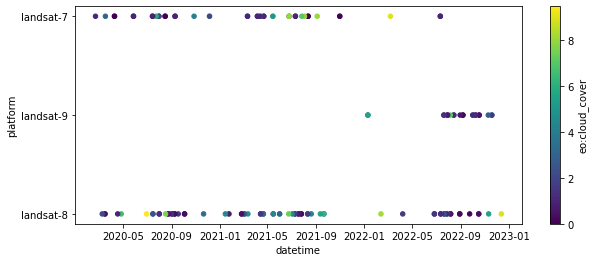

In [20]:
# Another key way to explore the data is through time:
fig,ax = plt.subplots(figsize=(10,4))
gf.plot.scatter(x='datetime', y='platform', c='eo:cloud_cover', cmap='viridis', ax=ax);

### Constructing large Xarray Datasets | Construir Datasets grandes

We saw earlier that we can construct multiband datasets by opening different files separately, renaming bands, and using `xr.concat`. This gets tedious with many more files, but there are now some great Xarray extensions like [ODC-STAC](https://odc-stac.readthedocs.io) that do this for you by reading just the metadata for each satellite image. Because in these cases you're working with data that excedes RAM, libraries like [Dask](https://docs.xarray.dev/en/stable/user-guide/dask.html) are used behind the scenes to parallelize the computation by diving the dataset into many smaller pieces.

---

Vimos anteriormente que podemos construir Xarray DataSets por medio de abrir archivos distintos, renombrar bandas, y usar `xr.concat`. Es cansador y ineficaz con muchos archivos, pero afortunadamente hay paquetes como [ODC-STAC] que maneja el proceso por medio de leer solo 'metadata' de cada imagen satelital. Debido a que DataSets muy grandes sobresale RAM, paquetes como Dask se utiliza a dividir en pedazos la computación:

In [21]:
%%time
ds = odc.stac.stac_load(items, 
                        bands=["nir08", "red"],
                        bbox=bbox_of_interest,
                        crs="utm",
                        resolution=250, # units of output CRS (UTM)
                        groupby='solar_day', # adjacent acquisition frames automatically merged
                        chunks={}, # Use Dask library to divy up large dataset!
)
ds

CPU times: user 859 ms, sys: 15.7 ms, total: 875 ms
Wall time: 872 ms


<xarray.Dataset>
Dimensions:      (y: 137, x: 155, time: 81)
Coordinates:
  * y            (y) float64 5.206e+06 5.206e+06 ... 5.173e+06 5.172e+06
  * x            (x) float64 5.761e+05 5.764e+05 ... 6.144e+05 6.146e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2020-02-21T18:34:19.587648 ... 2022-12...
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>

In [22]:
# There is a lot of STAC metadata we might want to keep track of in this xarray object:
ds = ds.assign_coords(dict(stac_id=gf.stac_id,
                           platform=gf.platform)
                     )
ds

<xarray.Dataset>
Dimensions:      (y: 137, x: 155, time: 81)
Coordinates:
  * y            (y) float64 5.206e+06 5.206e+06 ... 5.173e+06 5.172e+06
  * x            (x) float64 5.761e+05 5.764e+05 ... 6.144e+05 6.146e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2020-02-21T18:34:19.587648 ... 2022-12...
    stac_id      (time) object 'LE07_L2SP_046028_20200221_02_T1' ... 'LC08_L2...
    platform     (time) object 'landsat-7' 'landsat-8' ... 'landsat-8'
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>

In [23]:
# Optional: Save entire dataset locally 
#ds.to_netcdf('./data/landsat_ndvi.nc', engine='netcdf4')
#ds = xr.open_dataset('./data/landsat_ndvi.nc')

## Make plots | Figuras

It is always good to review [dataset documentation](https://www.usgs.gov/landsat-missions/landsat-collection-2-known-issues), and review your images in plots. Below we use Xarray's [FacetGrid plots](https://docs.xarray.dev/en/stable/generated/xarray.plot.FacetGrid.html) to look at the first 5 images. We immediately appreciate the variable spatial coverage of the images and also some data quality issues!

---

Es importante que revises documentación de cada archivo de datos, y también que veas cada imagen. Abajo usamos Xarray's FacetGrid plot para visualizar las primeras 5 imagenes. De inmediato podemos ver cobertura variable y problemas con fechas especificas:

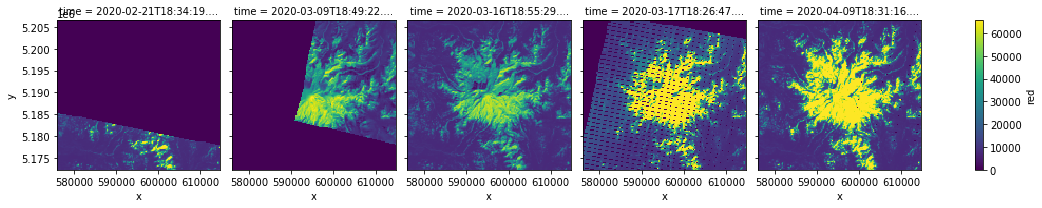

In [24]:
ds.red.isel(time=slice(0,5)).plot(col='time');

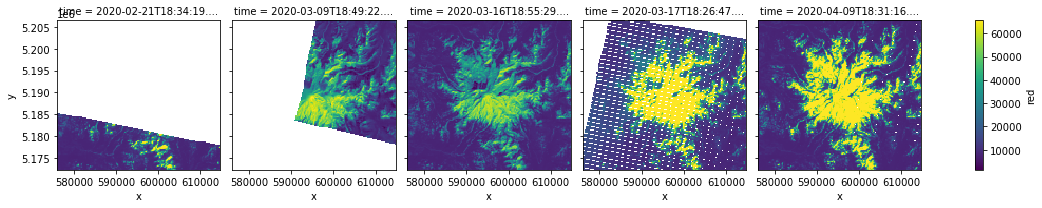

In [25]:
ds.red.where(ds.red!=0).isel(time=slice(0,5)).plot(col='time');

In [26]:
# ? What's up with 2020-03-17?
# NOTE: if you have a strange image and want to share it with someone else, you can use a URL like the following:
# https://planetarycomputer.microsoft.com/api/data/v1/item/map?collection=landsat-c2-l2&item=LE07_L2SP_045028_20200317_02_T1
ds.sel(time='2020-03-17')

<xarray.Dataset>
Dimensions:      (y: 137, x: 155, time: 1)
Coordinates:
  * y            (y) float64 5.206e+06 5.206e+06 ... 5.173e+06 5.172e+06
  * x            (x) float64 5.761e+05 5.764e+05 ... 6.144e+05 6.146e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2020-03-17T18:26:47.687291
    stac_id      (time) object 'LE07_L2SP_045028_20200317_02_T1'
    platform     (time) object 'landsat-7'
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>

## Practice Exercise: (5 minutes)

Thanks to metadata we know the 2020-03-17 acquisition is Landsat-7 which has ["Scan Line Corrector issues"](https://www.usgs.gov/landsat-missions/landsat-7)

**Plot other time ranges, can you find other data quality issues?**

---

Gracias a los metadatos sabemos que la imagen es de Landsat-7, lo cual tiene "Scan Line Corrector issues"

**Visualizar imagenes de otras fechas, podrás descubrir problemas de calidad?**

## NDVI Time Series 

In [27]:
ds = ds.where(ds!=0) 
ndvi = (ds.nir08 - ds.red) / (ds.nir08 + ds.red)
ndvi

<xarray.DataArray (time: 81, y: 137, x: 155)>
dask.array<truediv, shape=(81, 137, 155), dtype=float64, chunksize=(1, 137, 155), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.206e+06 5.206e+06 ... 5.173e+06 5.172e+06
  * x            (x) float64 5.761e+05 5.764e+05 ... 6.144e+05 6.146e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2020-02-21T18:34:19.587648 ... 2022-12...
    stac_id      (time) object 'LE07_L2SP_046028_20200221_02_T1' ... 'LC08_L2...
    platform     (time) object 'landsat-7' 'landsat-8' ... 'landsat-8'

In [28]:
print('dataset size (MB):', ndvi.nbytes / 1e6)

dataset size (MB): 13.76028


### Data Management | Manejo de datos

Since the total size of data isn't big (~10MB), load it all into memory from remote URLs. In the cell below we actually read 100's of Geotiffs, so it does take a little bit, but subsquent operations will be very fast. This would also be much faster on Planetary Computer JupyterHub because you don't have to transfer data over the internet!

---

Ya que el tamaño de datos no es grange, leamos todo de una vez del almacenimiento remoto. En la celula siguiente leemos cienes de Geotiffs asi que demora un poco, pero despues las computaciones son muy rapidas. Sería mucho más rapido en Planetary Computer JupyterHub porque no sea neceseario transmitir datos por internet global!

In [29]:
%%time 

ndvi = ndvi.compute()

CPU times: user 10.7 s, sys: 33.8 s, total: 44.5 s
Wall time: 1min 15s


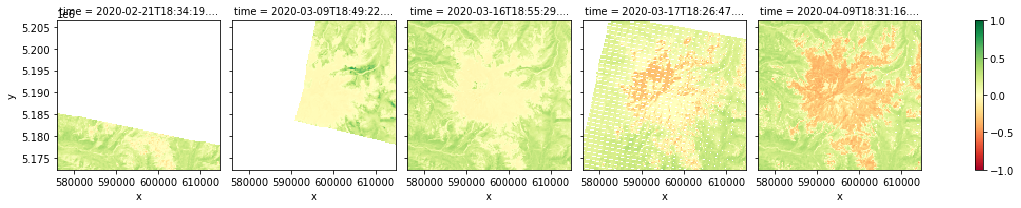

In [30]:
ndvi.isel(time=slice(0,5)).plot(col='time', vmin=-1, vmax=1, cmap='RdYlGn');

In [31]:
pixel = ndvi.sel(x=5.9e5, y=5.18e6, method='nearest')
pixel

<xarray.DataArray (time: 81)>
array([0.11975802,        nan, 0.12112806, 0.20720296, 0.21345085,
       0.13216137, 0.22007528, 0.2457277 ,        nan, 0.26744398,
              nan, 0.28955025, 0.26928675,        nan, 0.26826396,
              nan, 0.28347428,        nan, 0.27303043,        nan,
              nan,        nan, 0.19268702,        nan, 0.16476412,
       0.1931467 ,        nan,        nan, 0.21902486, 0.19355304,
              nan, 0.02093957, 0.03553812, 0.28452949, 0.19500757,
              nan, 0.23233944,        nan, 0.32079886, 0.29694005,
       0.30268168,        nan, 0.30718518, 0.27088036,        nan,
       0.30723938,        nan, 0.29111944, 0.29030504, 0.31922472,
              nan, 0.24797502, 0.25735188,        nan, 0.2053253 ,
       0.14873604,        nan,        nan, 0.2540366 , 0.28593442,
       0.28722329, 0.29872325, 0.28446964,        nan, 0.28779225,
       0.301944  , 0.27605997, 0.29232171, 0.3043674 , 0.28946896,
              nan, 0.2360286 , 0.23727534,        nan, 0.2026811 ,
       0.24431791, 0.21855265, 0.20544979, 0.19855929, 0.17835011,
              nan])
Coordinates:
    y            float64 5.18e+06
    x            float64 5.901e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2020-02-21T18:34:19.587648 ... 2022-12...
    stac_id      (time) object 'LE07_L2SP_046028_20200221_02_T1' ... 'LC08_L2...
    platform     (time) object 'landsat-7' 'landsat-8' ... 'landsat-8'

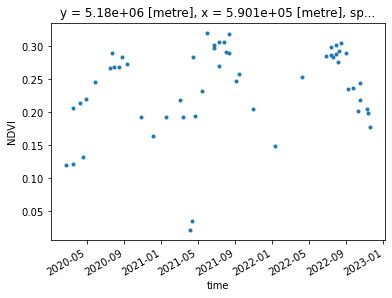

In [32]:
pixel.plot(marker='.', ls='')
plt.ylabel('NDVI');

### Groupby and Polyfit (analysis) 

Xarray has very powerful syntax for conducting analysis that closely follows Pandas. For example, let's explore temporal variability with `groupby` and `polyfit`

---

Xarray tiene funciones poderosas para analysis muy parecido a Pandas. Por ejemplo, vamos a explorar `groupby` y `polyfit`


In [33]:
monthly_mean = pixel.groupby('time.month').mean()
monthly_mean

<xarray.DataArray (month: 12)>
array([0.17094137, 0.11975802, 0.18522723, 0.16946736, 0.26628867,
       0.29518538, 0.28833985, 0.29051172, 0.25033225, 0.21271279,
       0.19411973, 0.16476412])
Coordinates:
    y            float64 5.18e+06
    x            float64 5.901e+05
    spatial_ref  int32 32610
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

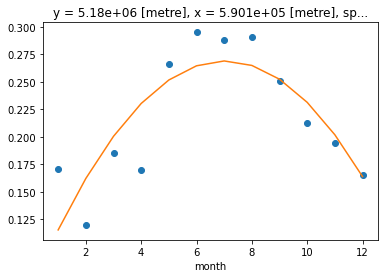

In [34]:
# Plot both the monthly mean for this pixel and quadratic fit
result = monthly_mean.polyfit(deg=2, dim='month')
quadratic = xr.polyval(monthly_mean.month, result.polyfit_coefficients)

fig,ax = plt.subplots()
monthly_mean.plot(marker='o', ls='', ax=ax)
quadratic.plot(ax=ax);

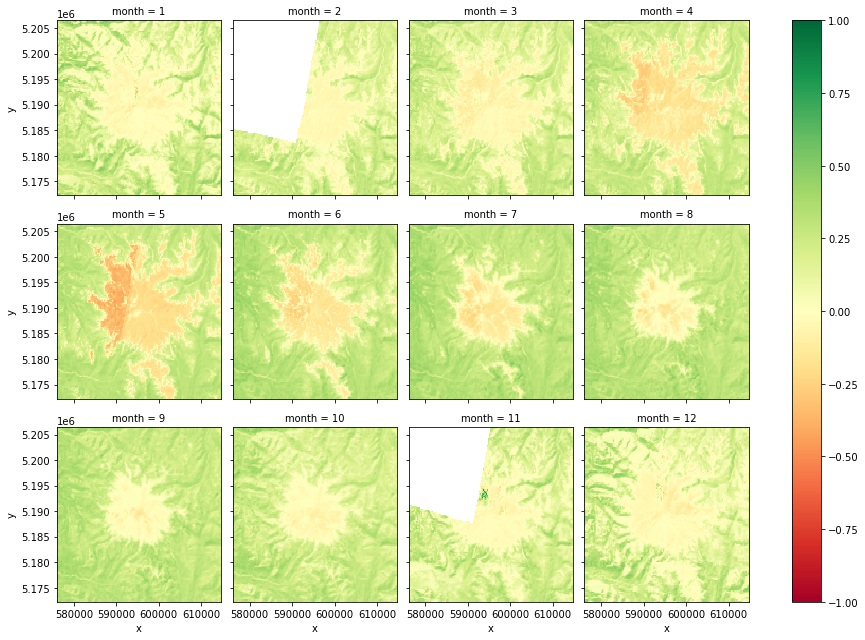

In [35]:
# Instead of a single pixel we can operate on the entire array with xarray!

monthly_means = ndvi.groupby('time.month').mean() 
monthly_means.plot(col='month', col_wrap=4, vmin=-1, vmax=1, cmap='RdYlGn');


In [36]:
# Sometimes its nice to go back to pandas for time series analysis or to use other tools
df = pixel.to_dataframe(name='ndvi')
df.head(3)

,y,x,spatial_ref,stac_id,platform,ndvi
time,,,,,,
2020-02-21 18:34:19.587648,5180125.0,590125.0,32610,LE07_L2SP_046028_20200221_02_T1,landsat-7,0.119758
2020-03-09 18:49:22.549274,5180125.0,590125.0,32610,LC08_L2SP_045027_20200309_02_T1,landsat-8,NaN
2020-03-16 18:55:29.962618,5180125.0,590125.0,32610,LC08_L2SP_046027_20200316_02_T1,landsat-8,0.121128


In [37]:
df.to_csv('my_timeseries.csv')

## Homework | Tarea

* Compute an NDVI Timeseries for an area that you are interested in
* Instead of filtering the entire scene by cloud percentage, use all scenes and mask pixels by estimated cloud coverage
* Compute a different band index like [Normalized Difference Snow Index](https://www.usgs.gov/landsat-missions/normalized-difference-snow-index)
* Try the same workflow but for a different dataset, like [ESA Sentinel-2](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a)

---

* Calcular NDVI serie de tiempo para una zona que te interese
* En vez de filtrar todos las imagenes por porcentage de nubes, utilce todas las imagenes y usar una mascara para echar pixeles no-validos
* Computar indice de bandas diferente - por ejemplo NDSI
* Intentar seguir el mismo analysis con un sensor diferente (Sentinel-2)


## Extra material to keep learning | Material extra para seguir aprendiendo

* The [Xarray Tutorial](https://tutorial.xarray.dev/intro.html) has lots of example notebooks from Fundamentals to Advanced
* The [Planetary Computer Documentation](https://planetarycomputer.microsoft.com/docs/overview/about) is extensive, with examples for many important remote sensing datasets.
* [Xarray Discussions](https://github.com/pydata/xarray/discussions) is great for Xarray-specific questions
* [Pangeo Forum](https://discourse.pangeo.io) is a great place for questions that use cloud-computing resources and large datasets stored on the cloud

---

* Xarray Tutorial tiene muchos ejemplos: basicos hasta avanzados.
* MS Planetary Computer Documentacion es amplio, con ejemplos para various archivos organizados por satelite
* [Xarray Discussions](https://github.com/pydata/xarray/discussions) es fantastico para preguntas acerca de Xarray
* [Pangeo Forum](https://discourse.pangeo.io) es un lugar para preguntas que tocan varias paquetes de python, especialmente acerca de computaciones con cloud-computing y archivos grandes